In [1]:
import os
import json
import re
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import BigInteger, Text
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import time
import pickle
import numpy as np

Pickle load time (s): 15.70366907119751

--- Analyzing: KLM for period: All ---
Created subgraph with 89638 nodes for KLM.
Extracted 56232 total customer tweets.
Using data from all available months.
Top 10 Languages Found: ['en', 'nl', 'und', 'es', 'de', 'pt', 'fr', 'ja', 'it', 'in']

Heat map data:
sentiment_label  Very Negative  Negative   Neutral  Positive  Very Positive
language                                                                   
en                    0.234304  0.147318  0.378222  0.061233       0.178922
nl                    0.213801  0.119124  0.323277  0.089118       0.254681
und                   0.029275  0.001331  0.784431  0.005988       0.178975
es                    0.262931  0.146552  0.261853  0.116379       0.212284
de                    0.293801  0.148248  0.307278  0.072776       0.177898
pt                    0.330508  0.169492  0.231638  0.070621       0.197740
fr                    0.265560  0.099585  0.327801  0.082988       0.224066
ja            

C:\Users\20243950\AppData\Local\Temp\ipykernel_20496\126066344.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["sentiment_label"] = pd.cut(df_filtered["sentiment"], bins=bins, labels=labels)
C:\Users\20243950\AppData\Local\Temp\ipykernel_20496\126066344.py:95: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_filtered.groupby(["language", "sentiment_label"]).size().reset_index(name="count")


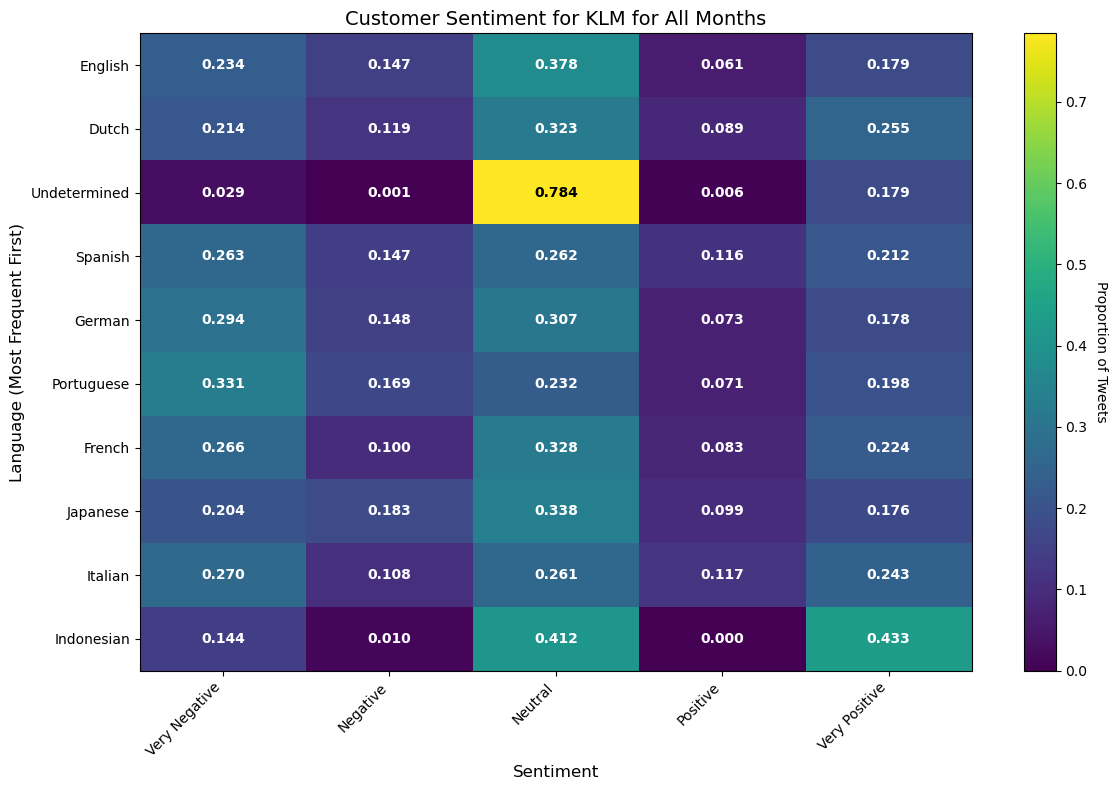

In [ ]:


# Choose the airline and month you want to analyze here.

CHOSEN_AIRLINE_NAME = "KLM"
CHOSEN_MONTH_NAME = "All" # Options: "January", "February", ..., "December", or "All"


AIRLINE_DATA = {
    "KLM": 56377143,
    "AirFrance": 106062176,
    "British_Airways": 18332190,
    "Lufthansa": 124476322,
    "Virgin_Atlantic": 20626359
}
ALL_AIRLINE_IDS = set(AIRLINE_DATA.values())
MONTH_MAP = {
    "January": 1, "February": 2, "March": 3, "April": 4, "May": 5, "June": 6,
    "July": 7, "August": 8, "September": 9, "October": 10, "November": 11, "December": 12
}


# Validate user choices
if CHOSEN_AIRLINE_NAME not in AIRLINE_DATA:
    print(f"Error: Airline '{CHOSEN_AIRLINE_NAME}' not found. Choose from {list(AIRLINE_DATA.keys())}")
    exit()
# Update validation to accept "All" as a valid choice for the month
if CHOSEN_MONTH_NAME != "All" and CHOSEN_MONTH_NAME not in MONTH_MAP:
    print(f"Error: Month '{CHOSEN_MONTH_NAME}' is not valid. Choose a full month name or 'All'.")
    exit()

chosen_airline_id = AIRLINE_DATA[CHOSEN_AIRLINE_NAME]

t0 = time.time()
script_dir = os.path.dirname(os.path.abspath(__file__)) 
# Navigate up to the project root
project_root = os.path.dirname(os.path.dirname(script_dir)) # Go up two levels

# Define the path to the data file
data_file_path = os.path.join(project_root, "data", "conversation_airlines_senti_correct.gpickle")

print(f"Loading graph from: {data_file_path}")

# Load the graph
with open(data_file_path, "rb") as f:
    G = pickle.load(f)
print(f"Pickle load time (s): {time.time() - t0}")
print(f"\n--- Analyzing: {CHOSEN_AIRLINE_NAME} for period: {CHOSEN_MONTH_NAME} ---")

# Dynamically create subgraph for the chosen airline
wccs = list(nx.weakly_connected_components(G))
keep_sets = [
    comp for comp in wccs
    if any(G.nodes[n].get("user") == chosen_airline_id for n in comp)
]
nodes_to_keep = set().union(*keep_sets)
H = G.subgraph(nodes_to_keep).copy()
print(f"Created subgraph with {H.number_of_nodes()} nodes for {CHOSEN_AIRLINE_NAME}.")

# Extract data from the subgraph
tweet_data = []
for node in H.nodes:
    if H.nodes[node].get("user") in ALL_AIRLINE_IDS:
        continue
    
    language = H.nodes[node].get("language")
    sentiment = H.nodes[node].get("sentiment_score")
    created = H.nodes[node].get("created")
    
    if language and sentiment is not None and created:
        tweet_data.append({
            "language": language,
            "sentiment": sentiment,
            "created": pd.to_datetime(created, errors='coerce')
        })

# Create the initial DataFrame
df = pd.DataFrame(tweet_data)
df.dropna(subset=['created'], inplace=True)
print(f"Extracted {len(df)} total customer tweets.")

# Conditionally filter the DataFrame based on CHOSEN_MONTH_NAME
if CHOSEN_MONTH_NAME == "All":
    # If "All" is chosen, use the entire DataFrame
    df_period = df.copy()
    print("Using data from all available months.")
else:
    # Otherwise, filter for the specific month
    chosen_month_number = MONTH_MAP[CHOSEN_MONTH_NAME]
    df_period = df[df['created'].dt.month == chosen_month_number]
    print(f"Filtered for {len(df_period)} customer tweets in {CHOSEN_MONTH_NAME}.")

if df_period.empty:
    print(f"No customer tweet data found for the selected period. Exiting.")
    exit()

# Data analysis
top_10_languages = df_period['language'].value_counts().nlargest(10).index.tolist()
print(f"Top 10 Languages Found: {top_10_languages}")

df_filtered = df_period[df_period['language'].isin(top_10_languages)]

bins = [-0.01, 0.125, 0.375, 0.625, 0.875, 1.01]
labels = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
df_filtered["sentiment_label"] = pd.cut(df_filtered["sentiment"], bins=bins, labels=labels)

counts = df_filtered.groupby(["language", "sentiment_label"]).size().reset_index(name="count")
counts["total"] = counts.groupby("language")["count"].transform("sum")
counts["proportion"] = counts["count"] / counts["total"]

language_order = top_10_languages
sentiment_order = ["Very Negative", "Negative", "Neutral", "Positive", "Very Positive"]
counts["language"] = pd.Categorical(counts["language"], categories=language_order, ordered=True)
counts["sentiment_label"] = pd.Categorical(counts["sentiment_label"], categories=sentiment_order, ordered=True)

heat_df = counts.pivot(index="language", columns="sentiment_label", values="proportion")
heat_df = heat_df.reindex(index=language_order, columns=sentiment_order).fillna(0)

print("\nHeat map data:")
print(heat_df)

# Plotting
language_map = {
    'en': 'English', 'und': 'Undetermined', 'nl': 'Dutch', 'fr': 'French',
    'es': 'Spanish', 'de': 'German', 'pt': 'Portuguese', 'in': 'Indonesian', 
    'it': 'Italian', 'ht': 'Haitian Creole', 'ja': 'Japanese', 'tr': 'Turkish',
    'hi': 'Hindi', 'tl': 'Tagalog', 'pl': 'Polish', 'et': 'Estonian'
}

fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(heat_df.values, cmap='viridis', aspect='auto')

ax.set_xticks(range(len(heat_df.columns)))
ax.set_yticks(range(len(heat_df.index)))
ax.set_xticklabels(heat_df.columns, rotation=45, ha='right')

full_language_names = [language_map.get(code, code) for code in heat_df.index]
ax.set_yticklabels(full_language_names)

for i in range(len(heat_df.index)):
    for j in range(len(heat_df.columns)):
        value = heat_df.iloc[i, j]
        text_color = 'white' if value < 0.5 else 'black'
        text = ax.text(j, i, f'{value:.3f}', 
                      ha='center', va='center', 
                      color=text_color, fontsize=10, fontweight='bold')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Proportion of Tweets', rotation=270, labelpad=15)

ax.set_xlabel('Sentiment', fontsize=12)
ax.set_ylabel('Language (Most Frequent First)', fontsize=12)

# Dynamic title and filename based on the chosen period
if CHOSEN_MONTH_NAME == "All":
    period_text = "for All Months"
    filename_period = "All_Months"
else:
    period_text = f"in {CHOSEN_MONTH_NAME}"
    filename_period = CHOSEN_MONTH_NAME

title = f"Customer Sentiment for {CHOSEN_AIRLINE_NAME} {period_text}"
filename = f"sentiment_heatmap_{CHOSEN_AIRLINE_NAME}_{filename_period}.png"
ax.set_title(title, fontsize=14)

plt.tight_layout()
plt.savefig(filename, dpi=300, bbox_inches="tight")
plt.show()

Pickle load time (s): 18.15298581123352

Processing data for KLM (ID: 56377143)...
  Found 89638 nodes in conversations involving KLM.

Processing data for Air France (ID: 106062176)...
  Found 21324 nodes in conversations involving Air France.

Processing data for British Airways (ID: 18332190)...
  Found 273420 nodes in conversations involving British Airways.

Processing data for Lufthansa (ID: 124476322)...
  Found 44975 nodes in conversations involving Lufthansa.

Processing data for Virgin Atlantic (ID: 20626359)...
  Found 60798 nodes in conversations involving Virgin Atlantic.

Created a single DataFrame with 490155 total customer tweets.

Aggregated mean sentiment data:
            airline month  sentiment
40        Lufthansa   May   0.496444
29              KLM   May   0.530415
7        Air France   May   0.457156
18  British Airways   May   0.530602
51  Virgin Atlantic   May   0.617915


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


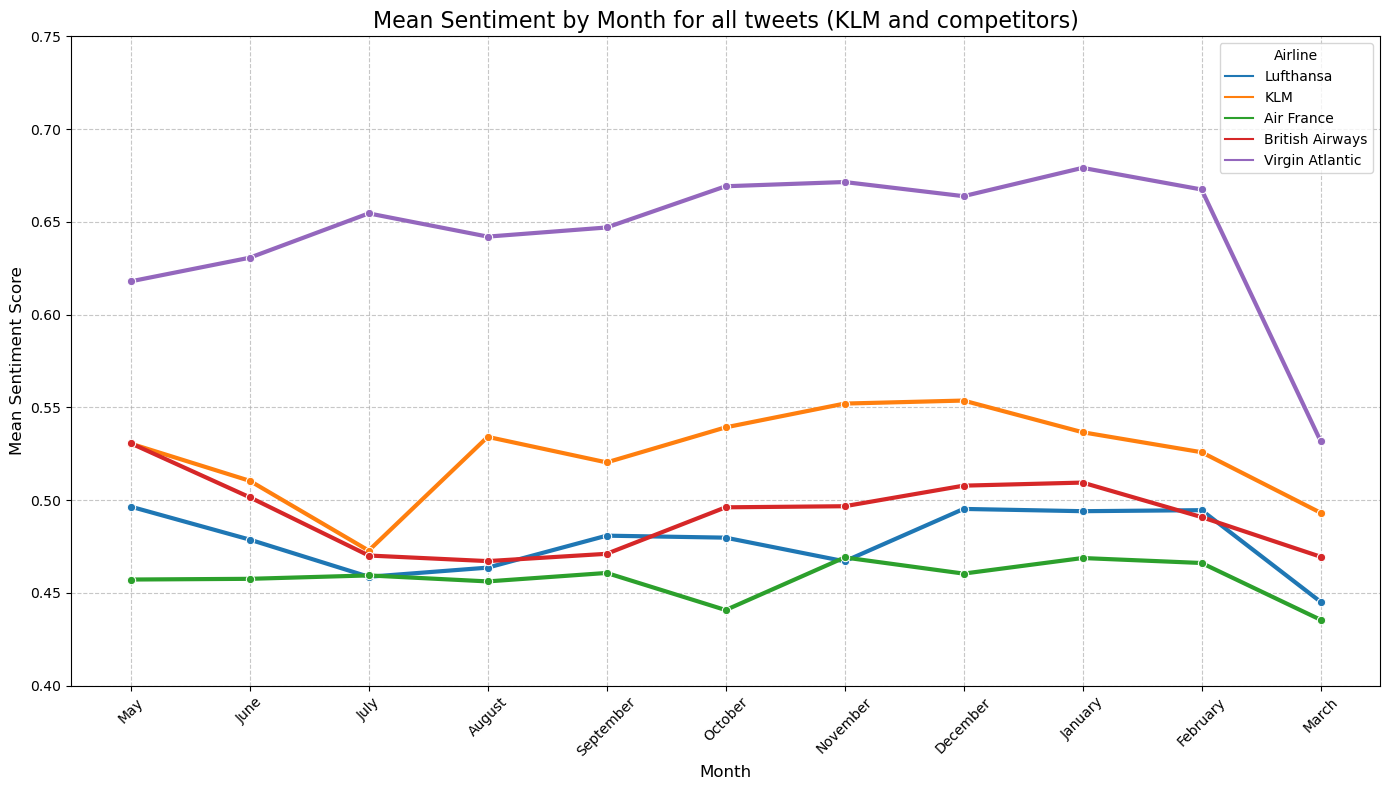

In [ ]:
import os
import json
import re
import pandas as pd
from sqlalchemy import create_engine
from sqlalchemy import BigInteger, Text
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import time
import pickle
import numpy as np


t0 = time.time()
script_dir = os.path.dirname(os.path.abspath(__file__)) 
# Navigate up to the project root
project_root = os.path.dirname(os.path.dirname(script_dir)) # Go up two levels

# Define the path to the data file
data_file_path = os.path.join(project_root, "data", "conversation_airlines_senti_correct.gpickle")

print(f"Loading graph from: {data_file_path}")

# Load the graph
with open(data_file_path, "rb") as f:
    G = pickle.load(f)
print("Pickle load time (s):", time.time() - t0)

# Define the target airlines with their IDs and names
target_airlines = {
    56377143: 'KLM',
    106062176: 'Air France',
    18332190: 'British Airways',
    124476322: 'Lufthansa',
    20626359: 'Virgin Atlantic'
}

# Define a master list of ALL airline IDs to filter out their tweets later
all_airline_ids = {
    56377143, 106062176, 18332190, 22536055, 124476322, 26223583,
    2182373406, 38676903, 1542862735, 253340062, 218730857,
    45621423, 20626359
}

# Pre-calculate weakly connected components once to save time
wccs = list(nx.weakly_connected_components(G))

# This list will hold data from all airlines before creating the final DataFrame
all_customer_tweets = []


# Loop through each airline 
for airline_id, airline_name in target_airlines.items():
    print(f"\nProcessing data for {airline_name} (ID: {airline_id})...")
    
    # Isolate conversations involving the current airline
    keep_sets = [
        comp for comp in wccs
        if any(G.nodes[n].get("user") == airline_id for n in comp)
    ]
    nodes_to_keep = set().union(*keep_sets)
    H = G.subgraph(nodes_to_keep)
    print(f"  Found {H.number_of_nodes()} nodes in conversations involving {airline_name}.")
    
    # Extract customer tweets from this airline's conversations
    for node in H.nodes:
        user_id = H.nodes[node].get("user")
        
        created = H.nodes[node].get("created")
        sentiment = H.nodes[node].get("sentiment_score")
        
        if created is not None and sentiment is not None:
            try:
                dt = pd.to_datetime(created)
                # Append a dictionary with all necessary info
                all_customer_tweets.append({
                    'airline': airline_name,
                    'created': dt,
                    'sentiment': sentiment
                })
            except:
                continue

# Create and prepare the dataframe
df = pd.DataFrame(all_customer_tweets)
print(f"\nCreated a single DataFrame with {len(df)} total customer tweets.")

# Convert 'created' column to datetime objects
df["created"] = pd.to_datetime(df["created"], errors="coerce")

# Create a 'month' column for grouping
df["month"] = df["created"].dt.month_name()



# Group by both airline and month to get the mean sentiment
mean_sentiment_by_month = (
    df.groupby(["airline", "month"])["sentiment"]
      .mean()
      .reset_index()
)

# Enforce a calendar order on the months for correct plotting
ordered_months = [
    "May", "June", "July", "August", "September", "October", 
    "November", "December", "January", "February", "March", "April"
]
mean_sentiment_by_month["month"] = pd.Categorical(
    mean_sentiment_by_month["month"], categories=ordered_months, ordered=True
)

# Sort the data to ensure lines connect correctly
mean_sentiment_by_month = mean_sentiment_by_month.sort_values("month")

print("\nAggregated mean sentiment data:")
print(mean_sentiment_by_month.head())


# Plotting
plt.figure(figsize=(14, 8))

# Use seaborn's 'hue' parameter to automatically create a line for each airline
sns.lineplot(
    data=mean_sentiment_by_month,
    x='month',
    y='sentiment',
    hue='airline',  
    marker='o',
    linestyle='-',
    linewidth=3 
)

plt.title("Mean Sentiment by Month for all tweets (KLM and competitors)", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Mean Sentiment Score", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0.40, 0.75)  
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Airline')
plt.tight_layout()
plt.savefig("sentiment_per_month_competitors_all.png", dpi=300, bbox_inches="tight")
plt.show()